In [18]:
# Ensure correct environment for GPy
import numpy, os, signal
if numpy.__version__ != "1.26.4":
    # 1. Uninstall conflicting packages
    !pip uninstall -y jax scipy jaxlib paramz pytensor > /dev/null 2>&1
    # 2. Install the versions required for GPy
    !pip install --force-reinstall numpy==1.26.4 scipy GPy paramz > /dev/null 2>&1
    # 3. Restart runtime to load correct NumPy ABI
    os.kill(os.getpid(), signal.SIGKILL)

!wget -q https://mlg.eng.cam.ac.uk/teaching/4f13/2526/cw/cw1a.mat > /dev/null
!wget -q https://mlg.eng.cam.ac.uk/teaching/4f13/2526/cw/cw1e.mat > /dev/null
!wget -q https://raw.githubusercontent.com/cambridge-mlg/4f13-courseworks/refs/heads/main/2526/cw1/gp.py > /dev/null

In [19]:
import GPy
import numpy as np
import gp as cw1utils

In [20]:
### Arbitrary data, X and y
X = np.random.rand(20, 1) * 10  # 20 data points in 1D
y = np.sin(X) + (np.cos(X))**2 + np.random.randn(20, 1) * 0.5  # noisy opipbservations

## Loading Matlab arrays in Python

In [21]:
import scipy.io as sio

In [22]:
data = sio.loadmat("cw1a.mat")  # Note this will throw an error because the file does not exist!

X = np.asarray(data["x"], dtype=float)
y = np.asarray(data["y"], dtype=float)

## GP Model Definition with Various Kernels (using GPy):

### Single kernels

Squared exponential (SE) isotropic

In [23]:
k = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)
m.likelihood.variance = 1.0  # Note that this is the default value, so we don't strictly need to set it here unless we want a different initial value.

Periodic

In [24]:
k = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1.0, period=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

SE Automatic Relevance Determination (ARD)

In [25]:
k = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

### Combined kernels

Product of Periodic and SE Isotropic

In [26]:
k_per = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1.0, period=1.0, variance=1.0)
k_se  = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0, variance=1.0)
kernel = k_per * k_se
m = GPy.models.GPRegression(X, y, kernel)

Sum of two SE ARD Kernels

In [27]:
z = np.random.randn(4)
ell1 = np.exp(z[0])
sf1  = np.exp(z[1])
var1 = sf1**2

ell2 = np.exp(z[2])
sf2  = np.exp(z[3])
var2 = sf2**2

k1 = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=ell1, variance=var1)
k2 = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=ell2, variance=var2)
k  = k1 + k2

m = GPy.models.GPRegression(X, y, kernel=k)

## GP Model Hyperparameter Optimisation using Marginal Likelihood

Once a GP regression model is specified, we can optimise its hyperparameters by minimising the negative log marginal likelihood (which is equivalent to maximising the likelihood of the data under the model.)

In [28]:
m.optimize(optimizer='lbfgsb', max_iters=2000, messages=False)

## Utilities functions useful for producing figures to be included in report

MODEL SUMMARY
NEGATIVE LOG MARGINAL LIKELIHOOD: 10.4955
OPTIMISED HYPERPARAMETERS:
    Component 1:
      • lengthscale (ℓ): 0.119464
      • signal std (σ_f): 0.771635
    Component 2:
      • lengthscale (ℓ): 1312.58
      • signal std (σ_f): 0.466703
    Noise std (σ_n): 0.117676
LML: -10.495456
  • Data fit term: -37.500016
  • Complexity penalty: -95.924950
  • Constant term: -68.920390


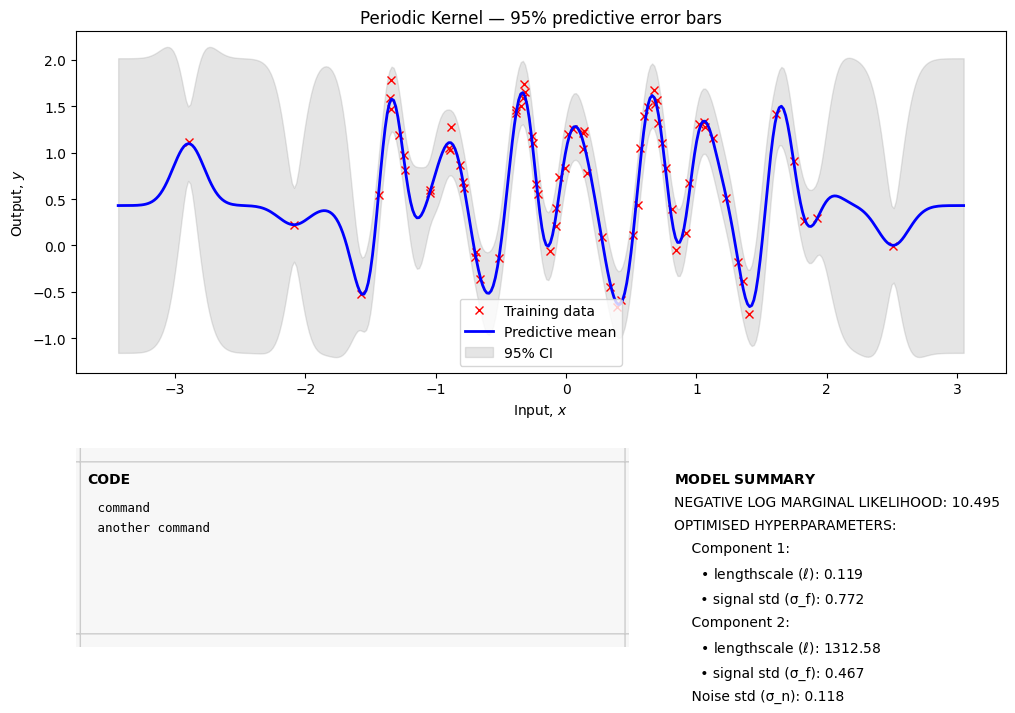

In [29]:
cw1utils.print_model_summary(m)
cw1utils.print_model_marginal_likelihood(m)
cw1utils.plot_predictive_error_bars(m, X, y, "\n command\n another command")

# cw1utils.plot_2d_predictive(mA, mB, codeA=None, codeB=None, save_path=None)
# cw1utils.plot_sampled_functions(X, F, code_snippet, n_draws=3, save_path=None)